In [161]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


### Прогнозирование уровня средней заработной платы в России 

WAG_C_M.csv

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для p,q,P,Q
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
7. Прогнозирование с помощью финальной модели.

In [162]:
data = pd.read_csv('WAG_C_M.csv','\;') 
# читаем данные

C:\Users\ilyab\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


#### Добавляем  данные за 2016 - 2018 годы

In [163]:
df2 = data
df1 = pd.DataFrame([['01.09.2016',35843.0],['01.10.2016',35749.0],['01.11.2016',36195.0],['01.12.2016',47554.0],['01.01.2017',34422.0],['01.02.2017',35497.0],['01.03.2017',37899.0],['01.04.2017',39225.0],['01.05.2017',39679.0],['01.06.2017',41454.0],['01.07.2017',38073.0],['01.08.2017',37099.0],['01.09.2017',38047.0],['01.10.2017',38333.0],['01.11.2017',38848.0],['01.12.2017',51197.0],['01.01.2018',39017.0],['01.02.2018',40443.0],['01.03.2018',42364.0],['01.04.2018',43381.0],['01.05.2018',44076.0],['01.06.2018',45848.0],['01.07.2018',42413.0],['01.08.2018',41364.0],['01.09.2018',41774.0],['01.10.2018',42000.0]], columns = ('month', 'WAG_C_M'))

In [164]:
salary = pd.concat([df2,df1],ignore_index=True)
# объединяем их

In [165]:
salary.to_csv('Wag.csv')
# записываю в файл

#### Визуализируем Ряд

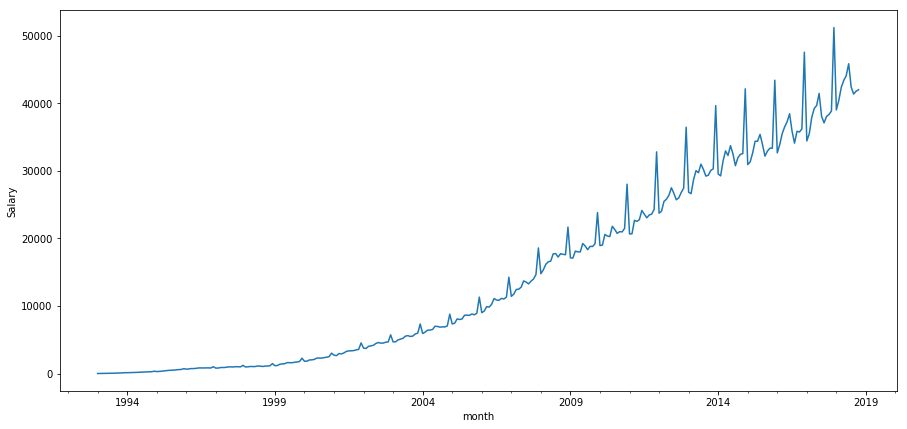

In [168]:
salary = pd.read_csv('Wag.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
# salary.WAG_C_M = salary.WAG_C_M * 1000
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()
salary = salary.drop(['Unnamed: 0'], axis='columns')

У ряда есть явный тренд и у него разная дисперсия. Проведем формальную проверку стационарности+ STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998647


<Figure size 1080x720 with 0 Axes>

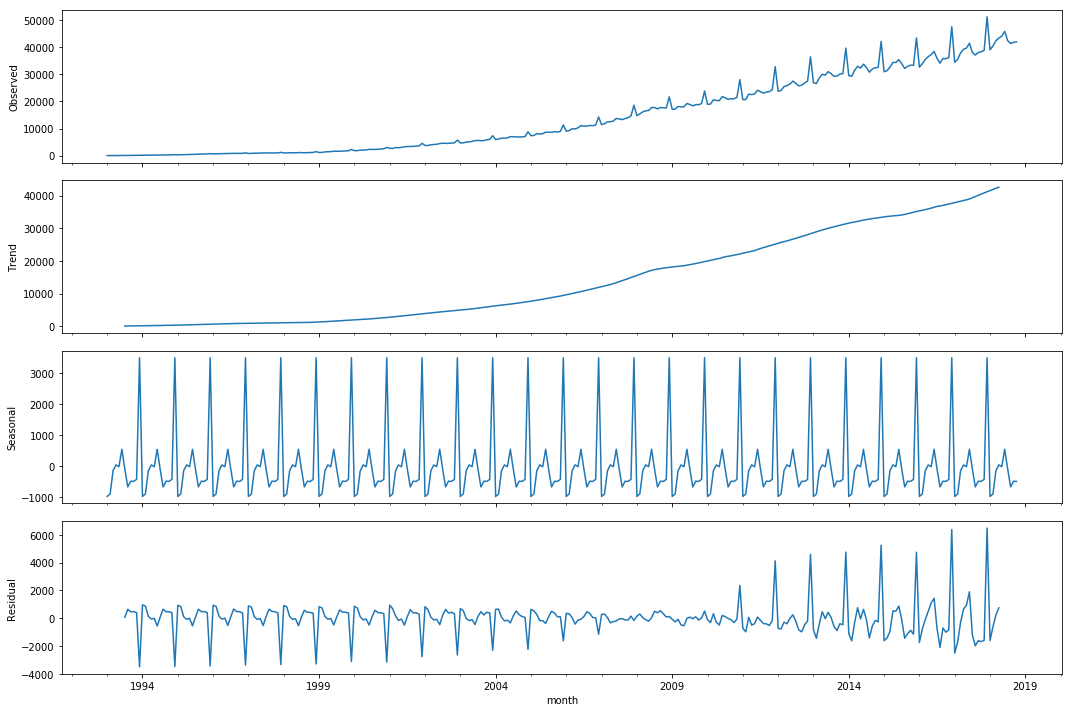

In [169]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.281998
Критерий Дики-Фуллера: p=0.725710


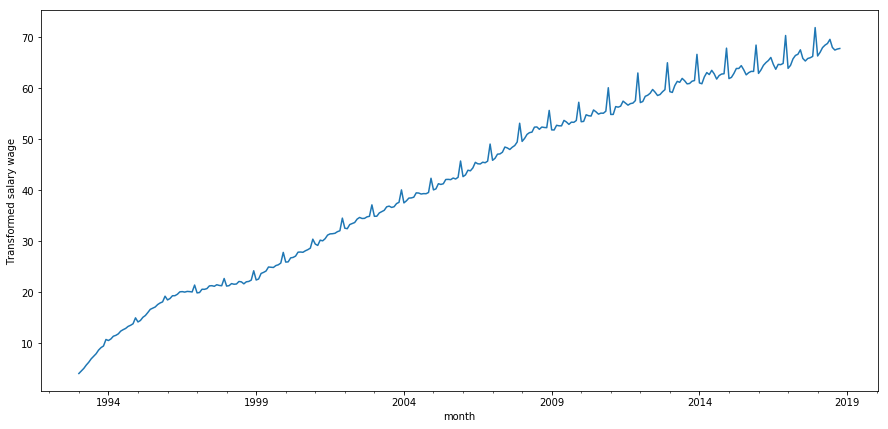

In [170]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.149189


<Figure size 1080x720 with 0 Axes>

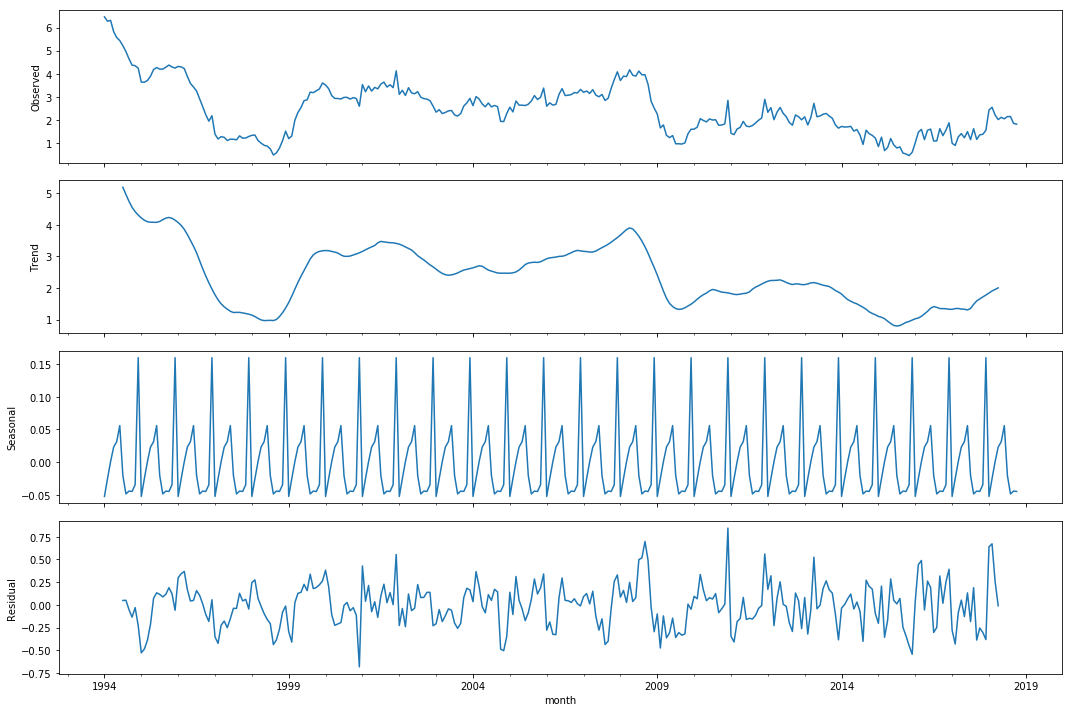

In [171]:
salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff[12:])[1])


Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

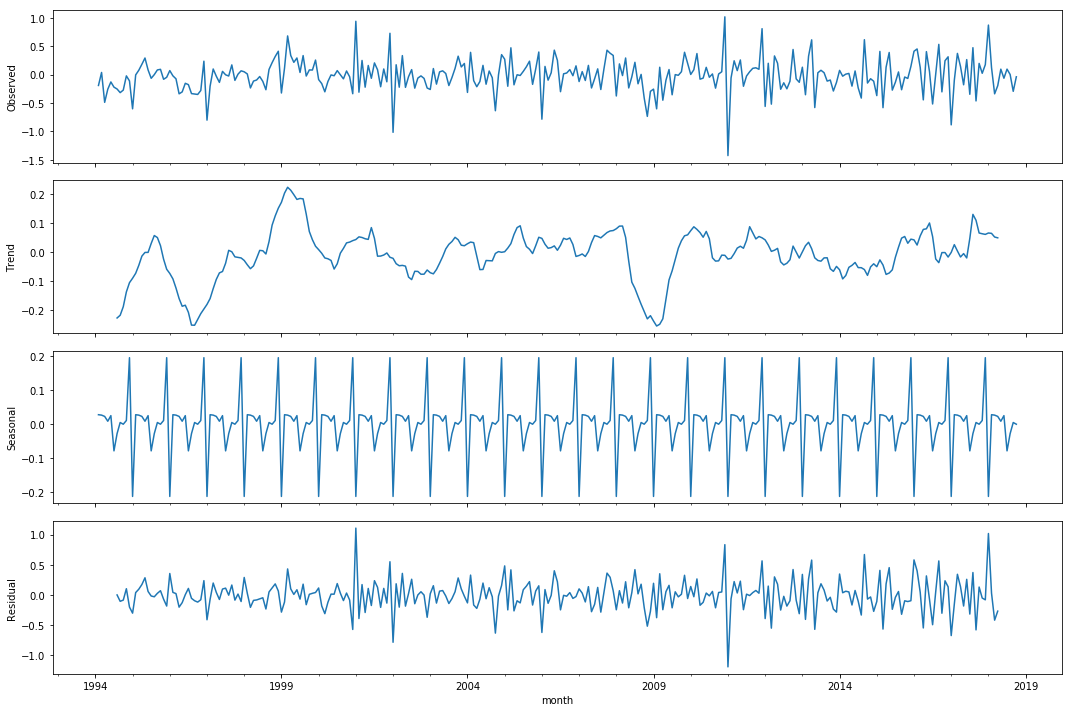

In [172]:
salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

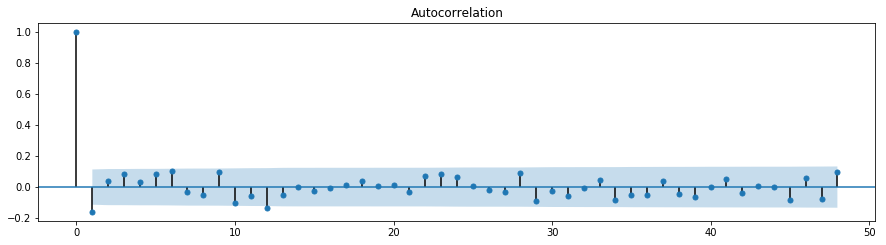

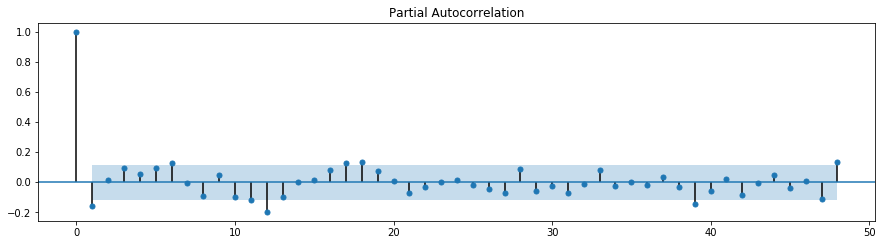

In [173]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=4, p=6

In [181]:
ps = range(0, 7)
d=1
qs = range(0,2)
Ps = range(0, 5)
D=1
Qs = range(0,2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

140

In [182]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
Wall time: 7min 24s


In [183]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
119  (6, 0, 4, 1)  89.912092
69   (3, 1, 4, 1)  91.695054
109  (5, 1, 4, 1)  91.721580
129  (6, 1, 4, 1)  91.762562
89   (4, 1, 4, 1)  92.861683


Лучшая модель

Минимальный AIC мы получаем для модели с параметрами (6,0,1,1). Модели с более маленькими коофициентами имеют существенную разницу в AIC, как лучшую модель берем именно ее. Посмотрим на параметры лучшей модели

In [184]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  310
Model:             SARIMAX(6, 1, 0)x(4, 1, 1, 12)   Log Likelihood                 -32.956
Date:                            Tue, 01 Jan 2019   AIC                             89.912
Time:                                    22:11:28   BIC                            134.237
Sample:                                01-01-1993   HQIC                           107.657
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2003      0.047     -4.277      0.000      -0.292      -0.109
ar.L2         -0.0414      0.065   

Её остатки:

Критерий Стьюдента: p=0.956474
Критерий Дики-Фуллера: p=0.000000


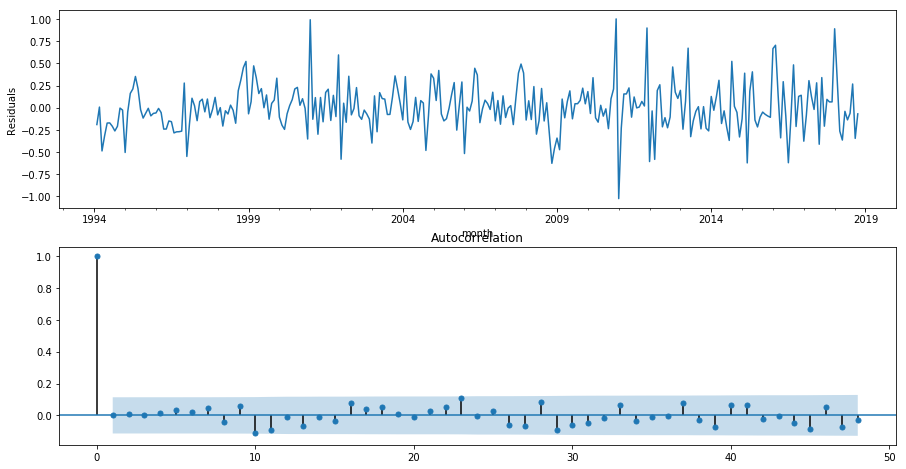

In [185]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

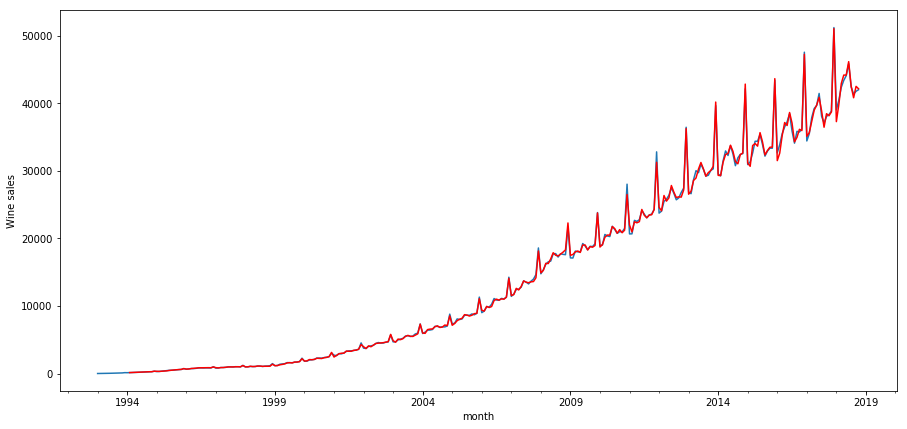

In [186]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Визуально модель описывает данные хорошо.

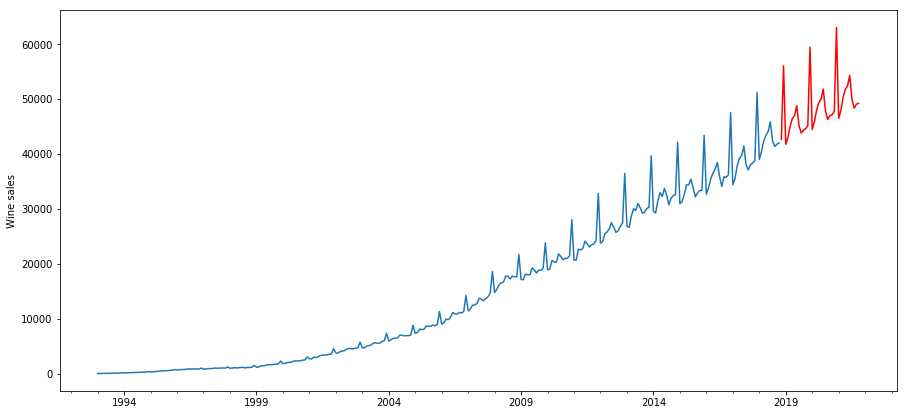

In [187]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=310, end=350), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Визуально модель делает достаточно хороший прогноз.

